## Network Structure and the Effectiveness of Crowd Based Requirements Processes

Title: Network Structure and the Effectiveness of Crowd Based Requirements Processes

Autors: M. Robinson, S. Sarkani and M. Mazzuchi

Affiliation: School of Engineering and Applied Science, George Washington University

Abstract: In recent years, researchers have argued that crowd sourcing generates better requirements by eliciting feedback from a broader range of stakeholders. Proposed benefits of crowd-based requirements process include a higher volume of requirements reflecting a broader array of use cases and a more engaged and committed user base. Researchers cite the inability of project teams to effectively manage an overwhelming volume of crowd-sourced system requirements as a possible drawback. Using a data set consisting of project management artifacts from 562 open source software projects, this paper uses generalized linear models to analyze how system performance varies as the percentage of requirements sourced from the crowd increases with respect to five measures of effectiveness: the average requirement close-out and response times, the average comment activity on requirements, the average number of issues per crowd member, and the average volume of requirements over time. Additionally, the models measure how the impact of additional crowd engagement changes with stakeholder network structure. For each measure of effectiveness except issues per crowd member, the analysis shows that the effect of increasing crowd engagement changes depending on the structure of the stakeholder network and the percentage of requirements sourced from the crowd. The results imply stakeholder networks with multiple, disjoint hubs and a low level of localized clustering absorb additional crowd engagement most effectively and suggest that systems engineers who seek to employ crowd-based requirements processes should encourage contributors to specialize and develop processes to route incoming requirements to the appropriate specialist.

#### Table of Contents

1. [Introduction](#intro)
    1. [Input Data](#input_data)
    1. [Exploratory Data Analysis](#eda)
    1. [Network Variables](#network_vars)
    
    
2. [Regression Results](#regression_results)
    1. [Comment Activity](#average_comments)
    1. [Issue Volume](#issues_over_time)
    1. [Response Time](#avg_first_comment)
    1. [Issues Per User](#issues_per_user)
    1. [Close Out Time](#avg_active_time)

### Import Dependencies

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from patsy import dmatrices
import scipy.stats
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.api as sms

from utils import glm_marginal_effect, compute_pca, calc_total_effect

## Part 1: Introduction <a id='intro'></a>

### Input Data <a id='input_data'></a>

The data for this project comes from GitHub and consists of project management data for 562 open source projects across five programming language. To ensure the project had enough data to build a coherent stakeholder network, only projects with over 30 requirements were considered. The list of packages for each language were sourced from curated lists of popular packages for each language, which are linked below. 

1. [JavaScript](https://github.com/sorrycc/awesome-javascript)
2. [Python](https://github.com/vinta/awesome-python)
3. [Java](https://github.com/akullpp/awesome-java)
4. [PHP](https://github.com/ziadoz/awesome-php)
5. [C++](https://github.com/fffaraz/awesome-cpp)

The data from the CSV file was aggregated after building the associated stakeholder networks. Aggregating this data requires access to the underlying contributor, issue and comment data from GitHub, which is too large to maintain in this repo. The logic for building the networks from the GitHub data can be found in the [`code/stakeholder_network.py`](https://github.com/MthwRobinson/sh-network-paper/blob/master/code/stakeholder_network.py). On request, the authors can provide a full Postgres SQL dump of the raw GitHub data.

In [3]:
data_file = os.path.join('..', 'github_data.csv')
data = pd.read_csv(data_file)

### Exploratory Data Analysis <a id='eda'></a>

We start off with some initial exploration of the data. First, we take a look at the distribution of crowd sourcing within the data set. As the histogram shows, the projects have a broad range of crowd sourcing intensity. This is good for our analysis because the data set captures a diversity of crowd sourcing behaviors.

(0.0, 1.0)

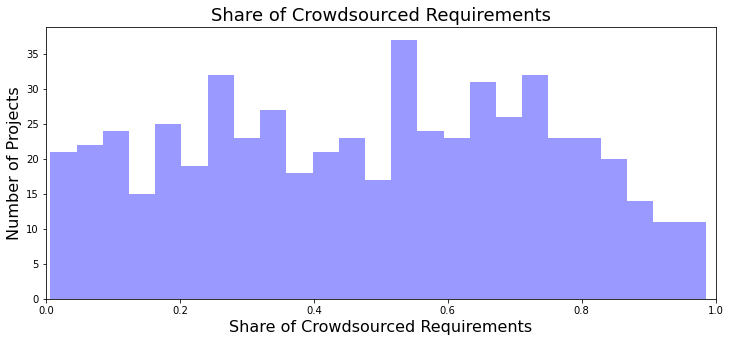

In [4]:
plt.figure(figsize=(12, 5))
sns.distplot(data['crowd_pct'], kde=False, color='blue', bins=25)
plt.title('Share of Crowdsourced Requirements', fontsize=18)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([0, 1])

Next we take a look at the distribution of a few of the variables in the data set. These are not the variables of interest, but are variables we intend to include in the analysis as controls. First we take a look at project age, which is normally distributed across the data set and ranges from a little over one year to ten years. It's worth noting that there are not many "young" projects because (1) it takes a project a while to gain enough popularity to be included in one of the curated lists and (2) limiting the data set to projects that have at least 30 requirements makes it harder for younger projects to make the cut.

(1.0, 10.0)

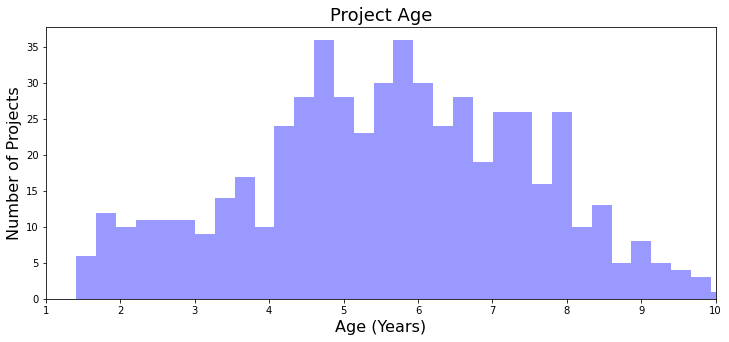

In [5]:
plt.figure(figsize=(12, 5))
sns.distplot(data['project_age']/365, kde=False, color='blue', bins=54)
plt.title('Project Age', fontsize=18)
plt.xlabel('Age (Years)', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([1, 10])

The next plot shows the total number of contributors in various project. Most projects have only a handful of contributors, although there's a long tail of projects with broader contributor bases. The data set considers anyone with a commit to be a contributor. As noted in the paper, this overestimates the number of project contributors because someone who submits only one pull request for a small fix isn't _truly_ a regular contributor to the project.

(1.0, 40.0)

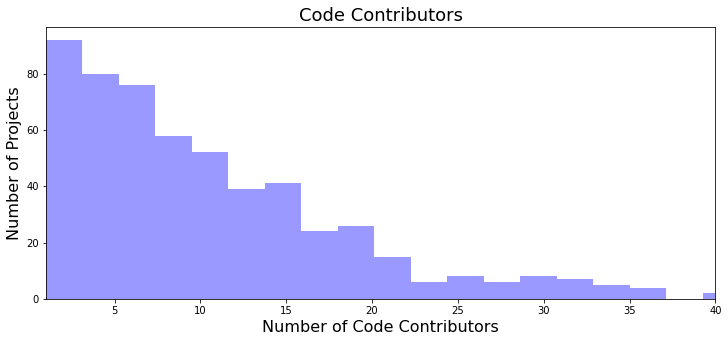

In [6]:
plt.figure(figsize=(12, 5))
sns.distplot(data['total_contributors'], kde=False, color='blue', bins=40)
plt.title('Code Contributors', fontsize=18)
plt.xlabel('Number of Code Contributors', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([1, 40])

The next plot shows the distribution of stakeholders across the data set. Stakeholders consist of both contributors and crowd members. As we would expect, the number of stakeholders exceeds the number of contributors for a project. Although it is still left skewed, the number of stakeholders does not fall off as quickly as the number of contributors.

(30.0, 1000.0)

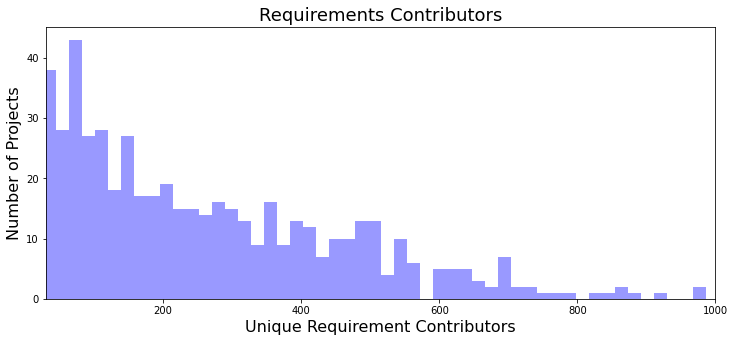

In [7]:
plt.figure(figsize=(12, 5))
sns.distplot(data['nodes'], kde=False, color='blue', bins=100)
plt.title('Requirements Contributors', fontsize=18)
plt.xlabel('Unique Requirement Contributors', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([30, 1000])

Finally, we provide a summary of the distribution for each of these variable.

In [8]:
data[['crowd_pct', 'project_age', 'total_contributors', 'nodes']].describe()

,crowd_pct,project_age,total_contributors,nodes
count,562.000000,562.000000,562.000000,562.000000
mean,0.480865,2054.546263,11.539146,274.754448
std,0.263940,708.712079,10.587185,253.108116
min,0.006711,513.000000,1.000000,7.000000
25%,0.265306,1611.000000,5.000000,83.250000
50%,0.500000,2073.500000,9.000000,209.000000
75%,0.699603,2571.000000,15.000000,398.250000
max,0.985294,5767.000000,86.000000,1891.000000


### Network Variables <a id='network_vars'></a>

For our next step, we want to see how the network structure variables relate to the crowd sourcing. We want to find out how these variables are correlated because if crowd sourcing only occurs in networks with a certain structure, it would be hard to determing whether crowd sourcing or network structure was driving changes in project management effectiveness.

We start out by plotting crowd sourcing against Gini coefficient, which is a measure of network concentration. As we can see, crowd sourcing is very evently distributed across the full range of values for Gini coefficients, which is a good property for our statistical analysis.

(0.0, 1.0)

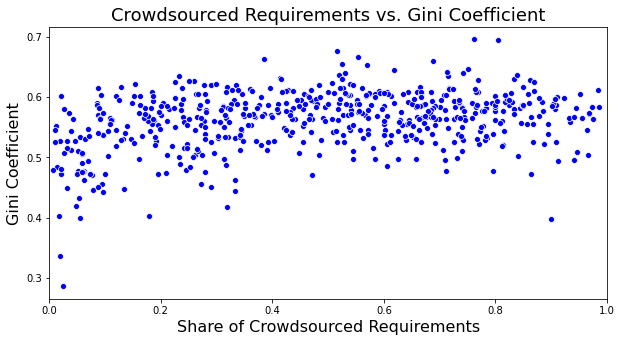

In [87]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['crowd_pct'], y=data['gini_coefficient'], color='blue')
plt.title('Crowdsourced Requirements vs. Gini Coefficient', fontsize=18)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)
plt.ylabel('Gini Coefficient', fontsize=16)
plt.xlim([0,1])

Next, we take a look at average minimum path, with is a measure of network breadth. The plot shows that broader networks more often occur in conjunction with more crowd sourcing. However, we see that crowd sourcing occurs even for relatively narrow networks. Again, this plot is encouraging for our research aims.

(0.0, 1.0)

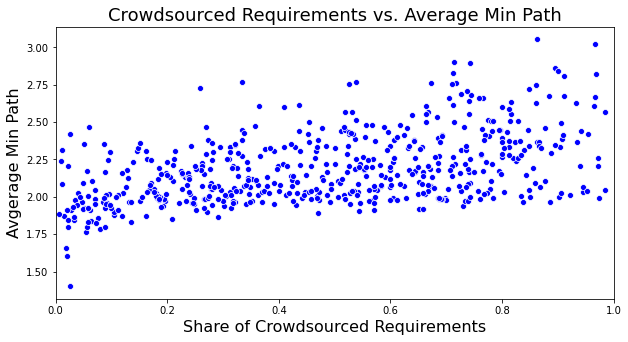

In [88]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['crowd_pct'], y=data['avg_min_path'], color='blue')
plt.title('Crowdsourced Requirements vs. Average Min Path', fontsize=18)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)
plt.ylabel('Avgerage Min Path', fontsize=16)
plt.xlim([0,1])

Finally, we take plot crowd sourcing against the clustering coefficient, which is a measuring of localized clustering in the network. Again we see a relative even spread of crowd sourcing acorss network structures, which is the statistical property we want for our analysis.

(0.0, 1.0)

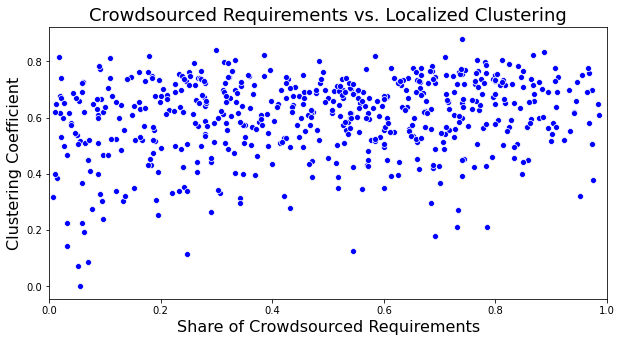

In [89]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=data['crowd_pct'], y=data['avg_clustering'], color='blue')
plt.title('Crowdsourced Requirements vs. Localized Clustering', fontsize=18)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)
plt.ylabel('Clustering Coefficient', fontsize=16)
plt.xlim([0,1])

We wrap up by summarizing the distribution of these variables. All in all, the initial exploration of the network structure reveals distributional properties which are encouraging for the proposed statistical analysis.

In [12]:
data[['gini_coefficient', 'avg_min_path', 'avg_clustering']].describe()

,gini_coefficient,avg_min_path,avg_clustering
count,562.000000,562.000000,562.000000
mean,0.561907,2.187393,0.601003
std,0.048177,0.232263,0.140855
min,0.285714,1.400000,0.000000
25%,0.535522,2.012390,0.522477
50%,0.568641,2.145767,0.627541
75%,0.592101,2.331743,0.704530
max,0.696200,3.054147,0.878524


## Regression Results <a id='regression_results'></a>

In [13]:
data['giniXavg_min_path'] = data['gini_coefficient'] * data['avg_min_path']
data['giniXclustering'] = data['gini_coefficient'] * data['avg_clustering']
data['clusteringXavg_min_path'] = data['avg_clustering'] * data['avg_min_path']

data['giniXavg_min_pathXcrowd_pct'] = data['gini_coefficient'] * data['avg_min_path'] * data['crowd_pct']
data['giniXclusteringXcrowd_pct'] = data['gini_coefficient'] * data['avg_clustering'] * data['crowd_pct']
data['clusteringXavg_min_pathXcrowd_pct'] = data['avg_clustering'] * data['avg_min_path'] * data['crowd_pct']

data['avg_clustering_2'] = data['avg_clustering']**2
data['avg_min_path_2'] = data['avg_min_path']**2
data['gini_coefficient_2'] = data['gini_coefficient']**2

data['crowd_pct_3'] = data['crowd_pct']**3

### Comment Activity <a id='average_comments'></a>

The first regression is on comment activity, which is defined as the average number of comment a requirement garners. The theory is that more comment activity points to both higher quality requirements and more engaged crowd members.

We start by plotting a histogram of average comment activity, which appears to have an approximately normal distribution. If you recall from the paper, we're using GLMs that assume a Gamma distribution for the paper. A Gamma distribution is also a reasonable distribution here because, under the proper parameterization, a Gamma can approrimate a normal. Specifically, a Gamma distribution is defined as a sum of Exponential distributions. Under the central limit distribution, the average (or scaled sum) of distributions with finite variace approaches a normal distribution, meaning a Gamma can be parameterized such that it approximates the normal. Of course, this approximation only applies to variables with a positive domain, which applies in th case of comment activity.

(1.0, 8.0)

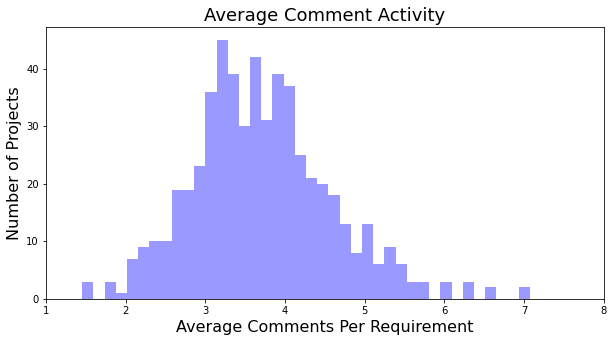

In [14]:
plt.figure(figsize=(10, 5))
sns.distplot(data['avg_comments'], kde=False, color='blue', bins=100)
plt.title('Average Comment Activity', fontsize=18)
plt.xlabel('Average Comments Per Requirement', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([1, 8])

In [15]:
data['avg_comments'].describe()

count    562.000000
mean       3.766143
std        1.079171
min        1.457227
25%        3.148360
50%        3.629720
75%        4.223124
max       15.493750
Name: avg_comments, dtype: float64

Next we test the distribution assumptions of the variable. We do this by running maximum likelihood estimation on the response variable, and then running a KS test assumming a Gamma distribution with the resulting parameter. The results indicate that either a normal distribution or a Gamma distribution are valid assumptions for the response variable. As noted above, under the right parameterization a Gamma can approximate a normal, so these results make sense.

In [16]:
gamma_params = scipy.stats.gamma.fit(data['avg_comments'])
norm_params = scipy.stats.norm.fit(data['avg_comments'])

In [17]:
gamma_params

(8.434450938214276, 0.9104787075691914, 0.3385712626530857)

In [18]:
scipy.stats.kstest(data['avg_comments'], 'gamma', gamma_params)

KstestResult(statistic=0.048380237421003974, pvalue=0.13936300196732776)

In [19]:
scipy.stats.kstest(data['avg_comments'], 'gamma', (8.43, .91, .33))

KstestResult(statistic=0.07046268591818433, pvalue=0.007165324989445984)

In [20]:
scipy.stats.kstest(data['avg_comments'], 'norm', norm_params)

KstestResult(statistic=0.09364497823096096, pvalue=9.692133432883285e-05)

Next we run a simple Gamma GLM without the topic variables. Our variables of interest are mostly significant and with a pseudo-R2 or 0.36, the model is okay. However, we suspect that the model will have more predictive power when we add in the topic variables because we suspect the content of the requirements will have a substantial impact on comment activity.

In [21]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2  + crowd_pct_3 +
    avg_min_pathXcrowd_pct + giniXavg_min_path + giniXclustering + clusteringXavg_min_path + 
    giniXavg_min_pathXcrowd_pct + giniXclusteringXcrowd_pct + clusteringXavg_min_pathXcrowd_pct +
    + avg_first_comment + avg_active_time + avg_clustering_2 + avg_min_path_2 + gini_coefficient_2 
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(len(res.params))
print(res.summary())

16
                            OLS Regression Results                            
Dep. Variable:           avg_comments   R-squared:                       0.385
Model:                            OLS   Adj. R-squared:                  0.368
Method:                 Least Squares   F-statistic:                     22.77
Date:                Thu, 03 Sep 2020   Prob (F-statistic):           2.04e-48
Time:                        22:24:58   Log-Likelihood:                -703.22
No. Observations:                 562   AIC:                             1438.
Df Residuals:                     546   BIC:                             1508.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Int

In [22]:
formula = """
avg_comments ~ crowd_pct + crowd_pct_2  +  crowd_pct_3 +
    avg_min_pathXcrowd_pct + giniXavg_min_path + giniXclustering + clusteringXavg_min_path + 
    giniXavg_min_pathXcrowd_pct + giniXclusteringXcrowd_pct + clusteringXavg_min_pathXcrowd_pct +
    + avg_first_comment + avg_active_time + avg_clustering_2 + avg_min_path_2 + gini_coefficient_2 
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.46433993729486356
16
                 Generalized Linear Model Regression Results                  
Dep. Variable:           avg_comments   No. Observations:                  562
Model:                            GLM   Df Residuals:                      546
Model Family:                   Gamma   Df Model:                           15
Link Function:                    log   Scale:                        0.042469
Method:                          IRLS   Log-Likelihood:                -596.45
Date:                Thu, 03 Sep 2020   Deviance:                       20.337
Time:                        22:24:58   Pearson chi2:                     23.2
No. Iterations:                    14                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------

<ipython-input-22-fc75899f8913>:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))


Next we run a fully specified version of the OLS model. Since the response variable is approximately normal, a simple OLS model could be appropriate here. The GLM might still be better because (1) the domain of the response variable is strictly positive and (2) the link function in the GLM helps us account for more complicated effects. Nevertheless, the simple OLS model looks pretty decent. The variables of interest are significant and the model has an R2 of 0.44

Next we run the fully specified GLM model. With an R2 of 0.52, it does a little better than the OLS model. Since that's the case and since we'd suspect the GLM will model the marginal effects better, we're choosing to go with this as our final model. It's also worth noting, the parameters on the variables of interest changed the simpler GLM that did not include topic variables, which indicates that omitting them would result in our model having biased estimators. As a result, the additional modeling complexity incured by including the topic variables is justified.

Next take a look at the residuals for model diagnostic. They don't look to bad, although there's some slight positive correlation between the response variables and the residuals. A regression of the residuals against the independent variables shows no correlation, meaning there is not significant concern about bias in the variables.

(1.0, 7.5)

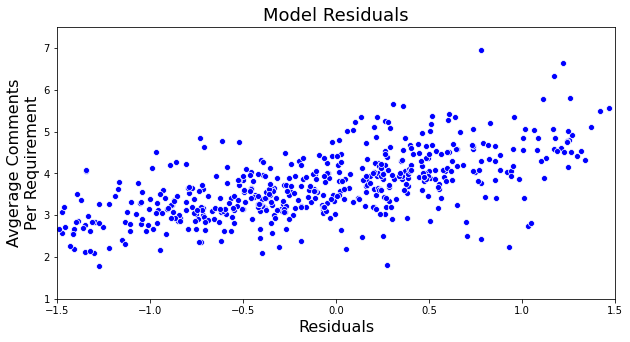

In [23]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['avg_comments'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Avgerage Comments\nPer Requirement', fontsize=16)
plt.xlim([-1.5, 1.5])
plt.ylim([1, 7.5])

(-2.2, 2.2)

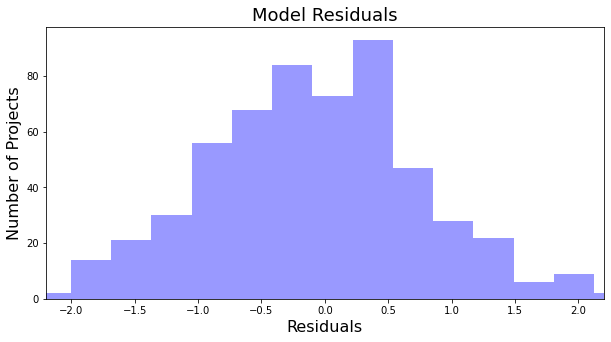

In [24]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=30)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([-2.2, 2.2])

In [25]:
data['avg_comments_resid'] = res.resid_anscombe_scaled
formula = """
avg_comments_resid ~ crowd_pct + crowd_pct_2  + crowd_pct:crowd_pct_2 +
    avg_min_pathXcrowd_pct + giniXavg_min_path + giniXclustering + clusteringXavg_min_path + 
    giniXavg_min_pathXcrowd_pct + giniXclusteringXcrowd_pct + clusteringXavg_min_pathXcrowd_pct +
    + avg_first_comment + avg_active_time + avg_clustering_2 + avg_min_path_2 + gini_coefficient_2 
"""
y_res, X_res = dmatrices(formula,
                         data=data, return_type='dataframe')
residual_mod = sm.OLS(y_res, X_res)
residual_res = residual_mod.fit()
print(residual_res.summary())

                            OLS Regression Results                            
Dep. Variable:     avg_comments_resid   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.026
Method:                 Least Squares   F-statistic:                   0.05167
Date:                Thu, 03 Sep 2020   Prob (F-statistic):               1.00
Time:                        22:24:59   Log-Likelihood:                -749.73
No. Observations:                 562   AIC:                             1531.
Df Residuals:                     546   BIC:                             1601.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                                        coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------
Interc

Next, we take a look at the total effects for each of the network variables. Gini coefficient and clustering coefficient both increasing comment activity on average, while increasing average minimum path has a negative effect.

The following shows the average effecting of increasing crowd sourcing, which is almost zero on average. However, as we'll see, the effect changes considerable depending on the current level of crowd sourcing.

In [26]:
calc_total_effect(data, res, X)

0.46509523496306054

The marginal effect plots show that crowd sourcing has a positive effect on comment activity for low levels of crowd sourcing and a negative effect for high levels of crowd sourcing. The cross over point for less concentrated, less locally clustered and broader networks occurred at a higher level of crowd sourcing.

Text(0.5, 0, 'Share of Crowdsourced Requirements')

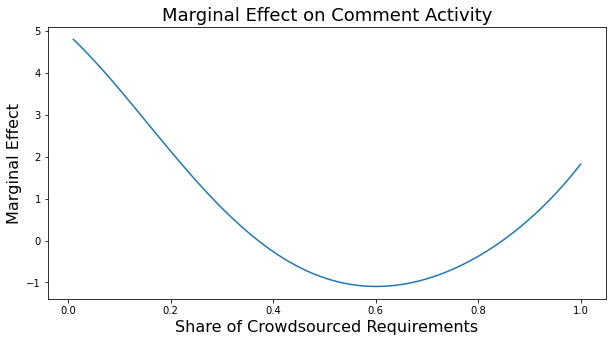

In [27]:
plt.figure(figsize=(10, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = calc_total_effect(data, res, X, crowd_pct=crowd_pct)
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.title('Marginal Effect on Comment Activity', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

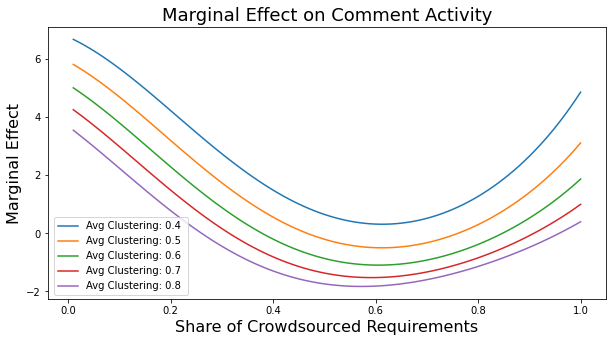

In [28]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.3), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Comment Activity', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

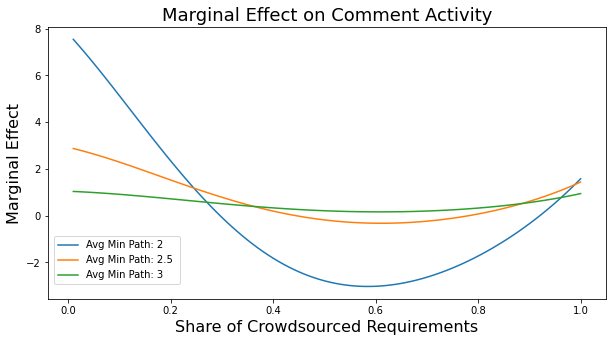

In [29]:
plt.figure(figsize=(10, 5))

for avg_min_path in [2, 2.5, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.23), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Comment Activity', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

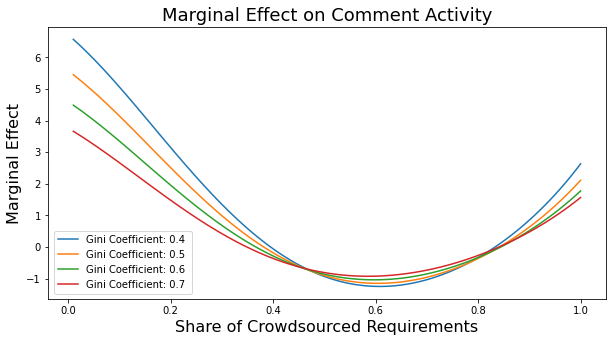

In [30]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)
    avg_clustering = data['avg_clustering']
    avg_min_path = data['avg_min_path']

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.25), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Comment Activity', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

### Issue Volume <a id='issues_over_time'></a>

The next regression involves issues volume. Gaining feedback from a broader range of stakeholders is posited as an advantage of crowd based requirements processes. However, if the volume of requirements is too high it can overwhelm project managers and make it difficult to prioritize.

First we plot the distribution of issue volume and check the distribution. According to the KS test, we're same in assuming  that issue volume conforms to a Gamma distribution.

In [31]:
data['issue_by_age'] = (data['total_issues'] / data['project_age']) * 365

(10.0, 100.0)

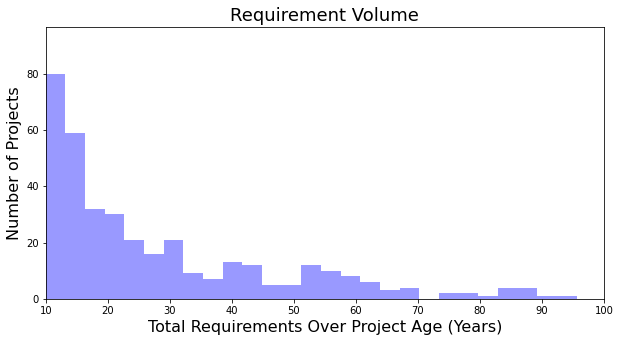

In [32]:
plt.figure(figsize=(10, 5))
sns.distplot(data['issue_by_age'], kde=False, color='blue', bins=100)
plt.title('Requirement Volume', fontsize=18)
plt.xlabel('Total Requirements Over Project Age (Years)', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([10, 100])

In [33]:
data['issue_by_age'].describe()

count    562.000000
mean      25.578766
std       32.117437
min        3.600789
25%        8.574642
50%       14.166460
75%       29.722574
max      320.909786
Name: issue_by_age, dtype: float64

In [34]:
gamma_params = scipy.stats.gamma.fit(data['issue_by_age'])
scipy.stats.kstest(data['issue_by_age'], 'gamma', gamma_params)

KstestResult(statistic=0.8151762849673976, pvalue=0.0)

Next we run a regression using the variables that were selecting during the variable selection process. The regression performs well, and achieve a pseudo-R2 of 0.66. 

In [35]:
formula = """
issue_by_age ~ crowd_pct + crowd_pct_2 + gini_coefficient + total_contributors + num_users
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.5376827321801088
6
                 Generalized Linear Model Regression Results                  
Dep. Variable:           issue_by_age   No. Observations:                  562
Model:                            GLM   Df Residuals:                      556
Model Family:                   Gamma   Df Model:                            5
Link Function:                    log   Scale:                         0.55392
Method:                          IRLS   Log-Likelihood:                -2157.5
Date:                Thu, 03 Sep 2020   Deviance:                       226.32
Time:                        22:25:53   Pearson chi2:                     308.
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept      

<ipython-input-35-fd6091c06d07>:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))


Next, we assess the model diagnostic. The scatter plot reveals some positive correlation between issue volume and the residuals. However, a regression of the residuals against the independent variables does not reveal any correlation. As a result, the regression results look good and there is no concern about biased estimators.

(2.9, 23.0)

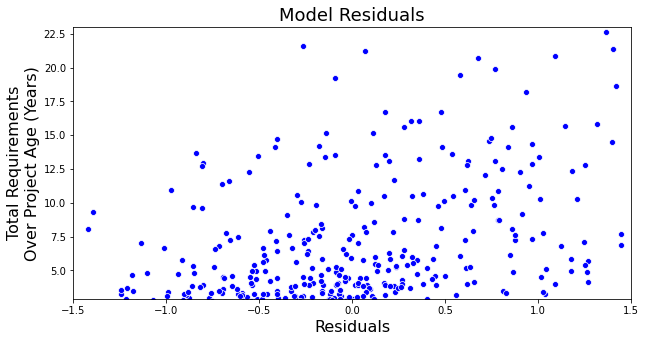

In [36]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['issues_over_time'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Total Requirements\nOver Project Age (Years)', fontsize=16)
plt.xlim([-1.5, 1.5])
plt.ylim([2.9, 23])

(-2.2, 2.2)

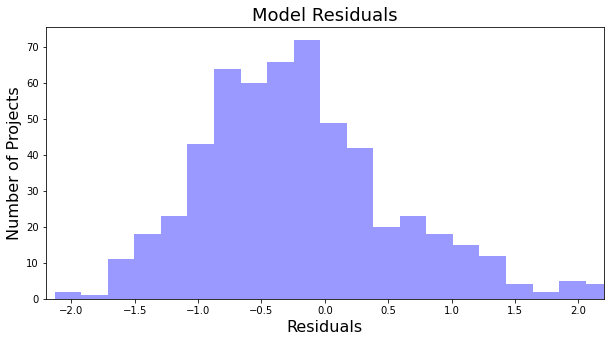

In [37]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=30)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([-2.2, 2.2])

In [38]:
data['issue_volume_resid'] = res.resid_anscombe_scaled
formula = """
issue_volume_resid ~ crowd_pct + crowd_pct_2 + gini_coefficient + total_contributors + num_users
"""
y_res, X_res = dmatrices(formula,
                         data=data, return_type='dataframe')
residual_mod = sm.OLS(y_res, X_res)
residual_res = residual_mod.fit()
print(residual_res.summary())

                            OLS Regression Results                            
Dep. Variable:     issue_volume_resid   R-squared:                       0.010
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.167
Date:                Thu, 03 Sep 2020   Prob (F-statistic):              0.324
Time:                        22:25:54   Log-Likelihood:                -684.64
No. Observations:                 562   AIC:                             1381.
Df Residuals:                     556   BIC:                             1407.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept             -0.1102      0

The overall effects show that inceasing localized clustering and the average min path have a negative effect on issue volume. By contrast, increasing network concentration increases issue volume. Overall, crowd sourcing decreases issue volume. However, as the plots show, the effect varies considerably depending on the current level of crowd sourcing. Specifically, crowd sourcing does not have a positive effect on issue volume until a project already sourcing 50-60% of its requirements from the crowd. After that, the impact on issue volume increases rapidly.

In [39]:
network_factors = ['gini_coefficient']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, data)
    print('{}: {}'.format(factor, effect))

gini_coefficient: 143.89235455385455


In [40]:
calc_total_effect(data, res, X)

-67.53096862015454

Text(0.5, 0, 'Share of Crowdsourced Requirements')

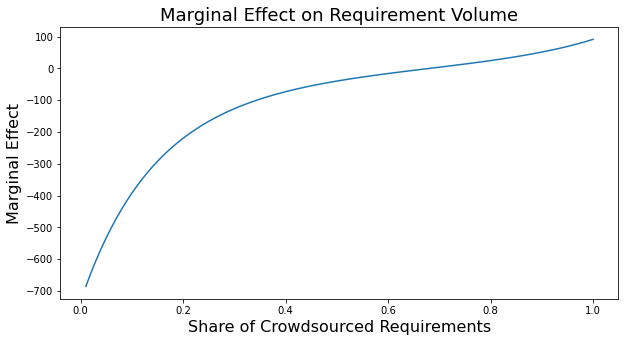

In [41]:
plt.figure(figsize=(10, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = calc_total_effect(data, res, X, crowd_pct=crowd_pct)
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.title('Marginal Effect on Requirement Volume', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

### Response Time <a id='avg_first_comment'></a>

The next regression concerns response time, which is the amount of time it takes for a member of the project team to respond after a new requirement is posted. Responding to requirements quickly helps keep crowd members engaged with the project.

First we plot the histogram of the response variable and check the distribution assumptions. The KS test shows that we are justified in assuming a Gamma distribution for the response variable.

In [42]:
data['avg_first_comment'].describe()

count    562.000000
mean      29.004449
std       37.018716
min        0.169014
25%        8.695482
50%       18.767917
75%       35.140768
max      389.746114
Name: avg_first_comment, dtype: float64

(0.0, 80.0)

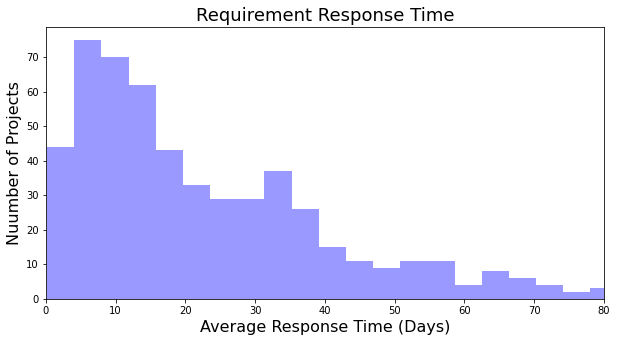

In [43]:
plt.figure(figsize=(10, 5))
sns.distplot(data['avg_first_comment'], kde=False, color='blue', bins=100)
plt.title('Requirement Response Time', fontsize=18)
plt.xlabel('Average Response Time (Days)', fontsize=16)
plt.ylabel('Nuumber of Projects', fontsize=16)
plt.xlim([0, 80])

In [44]:
gamma_params = scipy.stats.gamma.fit(data['avg_first_comment'])
scipy.stats.kstest(data['avg_first_comment'], 'gamma', gamma_params)

KstestResult(statistic=0.058813321205199665, pvalue=0.03934130906439515)

Next we run our GLM regression model using the variables that were selected during the variable selection process. The model performs reasonably well with an R2 of 0.41, and the interaction terms for several of the network variables are significant.

In [45]:
formula = """
avg_first_comment ~ -1 + crowd_pct_2 + gini_coefficientXcrowd_pct +
    + avg_clustering + avg_min_path + avg_min_path_2 +
    avg_clusteringXcrowd_pct  + gini_coefficient   +
    project_age
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.4206072229542569
8
                 Generalized Linear Model Regression Results                  
Dep. Variable:      avg_first_comment   No. Observations:                  562
Model:                            GLM   Df Residuals:                      554
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.77202
Method:                          IRLS   Log-Likelihood:                -2297.0
Date:                Thu, 03 Sep 2020   Deviance:                       347.20
Time:                        22:26:00   Pearson chi2:                     428.
No. Iterations:                    15                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

<ipython-input-45-0cd2c77023df>:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))


Next, we assess the validity of the regression. We see some positive correlation between the residuals and the response variable. However, a regression of the residuals against the indepedent variables shows no statistically significant correlation. This means bias in the estimators is not a major concern for this model.

In [46]:
formula = """
avg_first_comment ~ -1 + crowd_pct_2 + gini_coefficientXcrowd_pct +
    + avg_clustering + avg_min_path  +
    avg_clusteringXcrowd_pct  + gini_coefficient   +
    project_age
"""
y, X = dmatrices(formula,
                         data=data, return_type='dataframe')
mod = sm.OLS(y, X)
res = mod.fit()
print(res.summary())

                                 OLS Regression Results                                
Dep. Variable:      avg_first_comment   R-squared (uncentered):                   0.570
Model:                            OLS   Adj. R-squared (uncentered):              0.564
Method:                 Least Squares   F-statistic:                              105.0
Date:                Thu, 03 Sep 2020   Prob (F-statistic):                    2.30e-97
Time:                        22:26:00   Log-Likelihood:                         -2724.3
No. Observations:                 562   AIC:                                      5463.
Df Residuals:                     555   BIC:                                      5493.
Df Model:                           7                                                  
Covariance Type:            nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
-------------------------

In [47]:
res.params

crowd_pct_2                    72.480573
gini_coefficientXcrowd_pct   -273.751497
avg_clustering                -50.789184
avg_min_path                   34.134645
avg_clusteringXcrowd_pct      148.085432
gini_coefficient              -69.347153
project_age                     0.016156
dtype: float64

(0.0, 80.0)

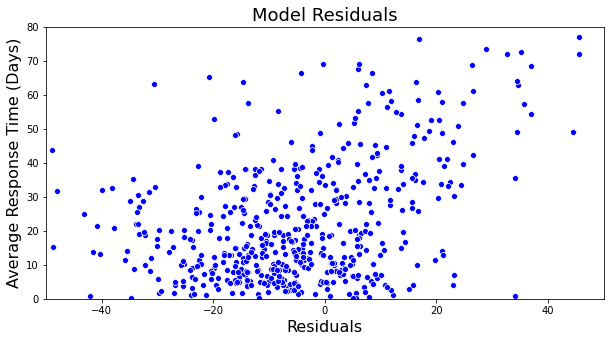

In [48]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid, y=data['avg_first_comment'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Average Response Time (Days)', fontsize=16)
plt.xlim([-50, 50])
plt.ylim([0, 80])

(-50.0, 50.0)

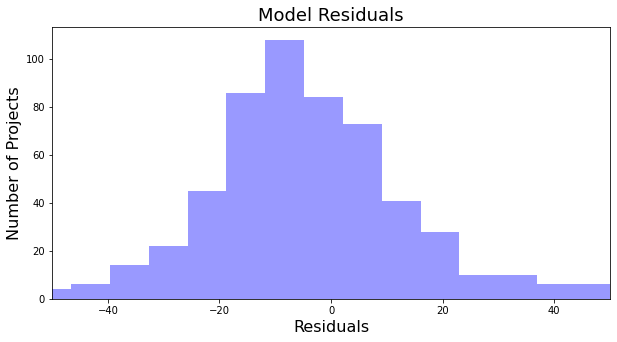

In [49]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid, kde=False, color='blue', bins=50)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([-50, 50])

In [50]:
data['response_time_resid'] = res.resid
formula = """
response_time_resid ~ -1 + crowd_pct_2 + gini_coefficientXcrowd_pct +
    + avg_clustering + avg_min_path  +
    avg_clusteringXcrowd_pct  + gini_coefficient   +
    project_age
"""
y_res, X_res = dmatrices(formula,
                         data=data, return_type='dataframe')
residual_mod = sm.OLS(y_res, X_res)
residual_res = residual_mod.fit()
print(residual_res.summary())

                                 OLS Regression Results                                 
Dep. Variable:     response_time_resid   R-squared (uncentered):                   0.000
Model:                             OLS   Adj. R-squared (uncentered):             -0.013
Method:                  Least Squares   F-statistic:                              0.000
Date:                 Thu, 03 Sep 2020   Prob (F-statistic):                        1.00
Time:                         22:26:02   Log-Likelihood:                         -2724.3
No. Observations:                  562   AIC:                                      5463.
Df Residuals:                      555   BIC:                                      5493.
Df Model:                            7                                                  
Covariance Type:             nonrobust                                                  
                                 coef    std err          t      P>|t|      [0.025      0.975]
---------------

Next, we look at the total effects for the model. Higher concentration increases response time, but the other network variables are negatively correlated with response time. Overall, crowd sourcing has a postive effect on response time. However, the plot shows that the effect of response time increases with more crowd sourcing and changes dramatically with network structure. It's noteworth that the response time for networks with low concentration increases dramatically at high levels of crowd sourcing. Likewise, networks with low levels of localized clustering maintain better response times when levels of crowd sourcing increase.

In [51]:
network_factors = ['avg_clustering', 'gini_coefficient', 'avg_min_path']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, data)
    print('{}: {}'.format(factor, effect))

avg_clustering: 751.6954259786177
gini_coefficient: -6127.46366614202
avg_min_path: 990.745915875401


In [52]:
calc_total_effect(data, res, X)

487.62353761088656

Text(0.5, 0, 'Share of Crowdsourced Requirements')

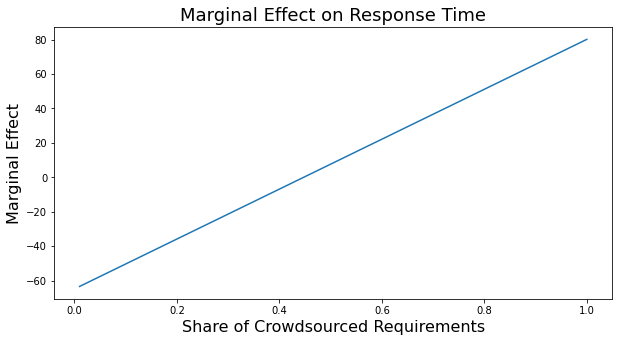

In [53]:
plt.figure(figsize=(10, 5))

marginal_effects = {'crowd_pct': [], 'effect': []}
for i in range(100):
    crowd_pct = (i+1)/100
    avg_effect = (2 * res.params['crowd_pct_2'] * crowd_pct + 
              res.params['gini_coefficientXcrowd_pct'] * data['gini_coefficient'].mean() +
              res.params['avg_clusteringXcrowd_pct'] * data['avg_clustering'].mean())
    marginal_effects['crowd_pct'].append(crowd_pct)
    marginal_effects['effect'].append(avg_effect)
        
marginal_effects = pd.DataFrame(marginal_effects)
sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'])

plt.title('Marginal Effect on Response Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

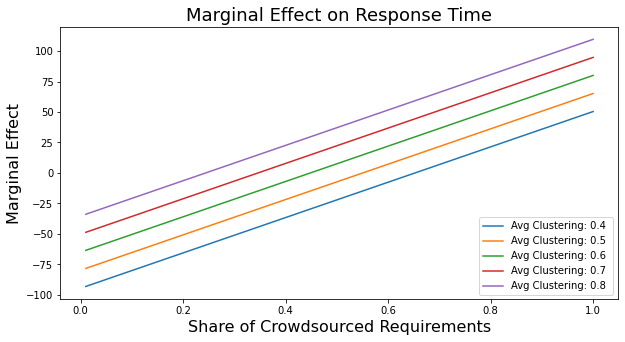

In [54]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = (2 * res.params['crowd_pct_2'] * crowd_pct + 
                  res.params['gini_coefficientXcrowd_pct'] * data['gini_coefficient'].mean() +
                  res.params['avg_clusteringXcrowd_pct'] * avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.75, 0.3), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Response Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

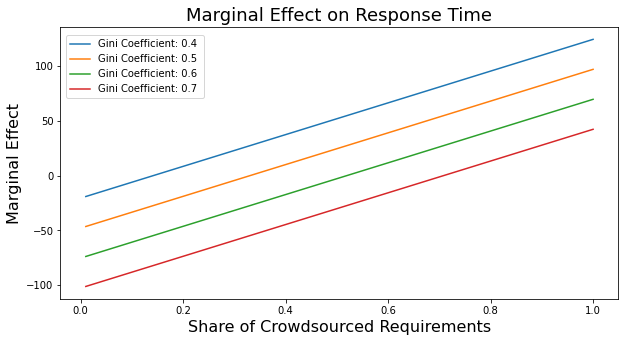

In [55]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = (2 * res.params['crowd_pct_2'] * crowd_pct + 
                  res.params['gini_coefficientXcrowd_pct'] * gini_coefficient +
                  res.params['avg_clusteringXcrowd_pct'] * data['avg_clustering'].mean())
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Response Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

### Issues Per User <a id='issues_per_user'></a>

Next, we take a look at issues per user. The idea behind this variable is that if crowd members return to submit additional requirement, that means they're continuing to remain engaged with the project. 

First, we plot a histogram and check the distribution assumptions. The KS test shows that we're justified in assuming a Gamma distribution for the response variable.

In [56]:
data['issues_per_user'].describe()

count    562.000000
mean       5.422194
std        8.544846
min        1.113402
25%        2.192618
50%        3.177866
75%        5.174578
max       97.000000
Name: issues_per_user, dtype: float64

(1.0, 20.0)

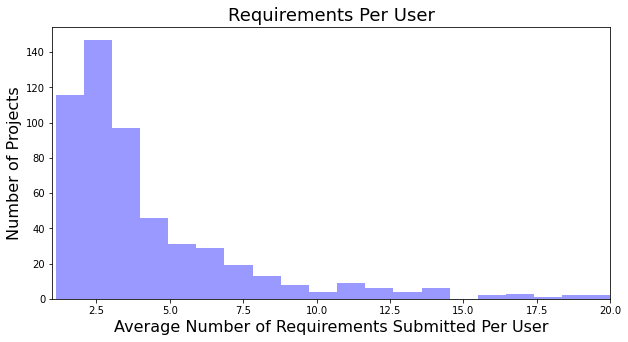

In [57]:
plt.figure(figsize=(10, 5))
sns.distplot(data['issues_per_user'], kde=False, color='blue', bins=100)
plt.title('Requirements Per User', fontsize=18)
plt.xlabel('Average Number of Requirements Submitted Per User', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([1, 20])

In [58]:
gamma_params = scipy.stats.gamma.fit(data['issues_per_user'])
scipy.stats.kstest(data['issues_per_user'], 'gamma', gamma_params)

KstestResult(statistic=0.6062539644102235, pvalue=1.5456242236602729e-198)

Next, we run the regression on the variables that were selected during the variable selection process. Although the model is quite good and crowd sourcing does effect issues per user, the impact of crowd sourcing does not appear to change with network structure.

In [59]:
formula = """
issues_per_user ~ crowd_pct + crowd_pct_2 + avg_min_path 
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.6440481133050244
4
                 Generalized Linear Model Regression Results                  
Dep. Variable:        issues_per_user   No. Observations:                  562
Model:                            GLM   Df Residuals:                      558
Model Family:                   Gamma   Df Model:                            3
Link Function:                    log   Scale:                         0.66202
Method:                          IRLS   Log-Likelihood:                -1281.1
Date:                Thu, 03 Sep 2020   Deviance:                       154.15
Time:                        22:26:09   Pearson chi2:                     369.
No. Iterations:                    21                                         
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.1701    

<ipython-input-59-189257cd69a4>:6: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))


Next, we perform model diagnostics. The scatter plot shows positive correlation between the residuals and the response variable. Performing a regression of the residuals against the independent variables reveals positive correlation between the residuals and `crowd_pct` and negative correlation between the residuals and `crowd_pct_2`. This correlation implies bias toward zero for both variables, meaning the model underestimates the effect of crowd sourcing. However, since the magnitude is about the same for both variables, the maximum of the crowd percentage effect curve remains approximately the same.

(0.0, 25.0)

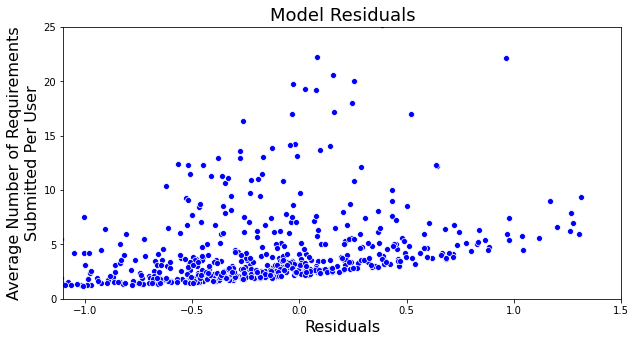

In [60]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['issues_per_user'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Average Number of Requirements\nSubmitted Per User', fontsize=16)
plt.xlim([-1.1, 1.5])
plt.ylim([0, 25])

(-1.1, 1.5)

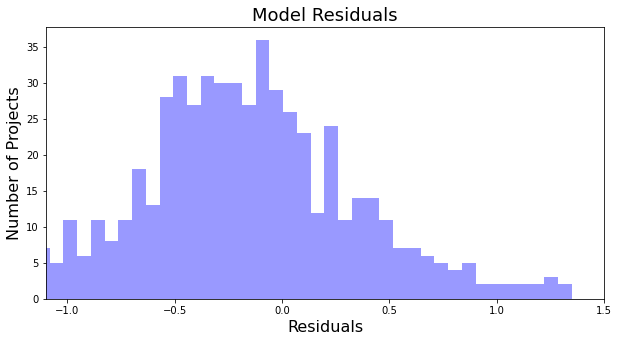

In [61]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=100)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([-1.1, 1.5])

In [62]:
data['issues_per_user_resid'] = res.resid_anscombe_scaled
formula = """
issues_per_user_resid ~ crowd_pct + crowd_pct_2 + avg_min_path
"""
y_res, X_res = dmatrices(formula,
                         data=data, return_type='dataframe')
residual_mod = sm.OLS(y_res, X_res)
residual_res = residual_mod.fit()
print(residual_res.summary())

                              OLS Regression Results                             
Dep. Variable:     issues_per_user_resid   R-squared:                       0.056
Model:                               OLS   Adj. R-squared:                  0.051
Method:                    Least Squares   F-statistic:                     11.00
Date:                   Thu, 03 Sep 2020   Prob (F-statistic):           5.01e-07
Time:                           22:26:10   Log-Likelihood:                -513.37
No. Observations:                    562   AIC:                             1035.
Df Residuals:                        558   BIC:                             1052.
Df Model:                              3                                         
Covariance Type:               nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0

Finally, we take a look at the effects. Overall, crowd sourcing has a negative effect on issues per user. However, there is a cross over point at around 66%. Beyond that point, increasing crowd sourcing has a positive effect on issues per user. This implies that there are some projects with a small number of highly active crowd members.

In [63]:
glm_marginal_effect('avg_min_path', res, X, data)

2.782951542693327

In [64]:
calc_total_effect(data, res, X)

-19.481844172592627

In [65]:
8.29 / (2*6.19)

0.6696284329563812

### Close Out Time <a id='avg_active_time'></a>

The final regression looks at close out time, or the time from when the issue is opened until when activity on the requirement ceases. As with response time, the theory is that crowd members remain more engaged if the project team addresses their requirements more quicky.

First, we plot a histogram of the variable and check the distribution. The KS test shows that we are justified in assuming a Gamma distribution for the variable.

In [66]:
data['avg_active_time'].describe()

count    562.000000
mean      68.128883
std       52.051931
min        0.675000
25%       31.744782
50%       55.716894
75%       88.387924
max      531.482618
Name: avg_active_time, dtype: float64

(1.0, 200.0)

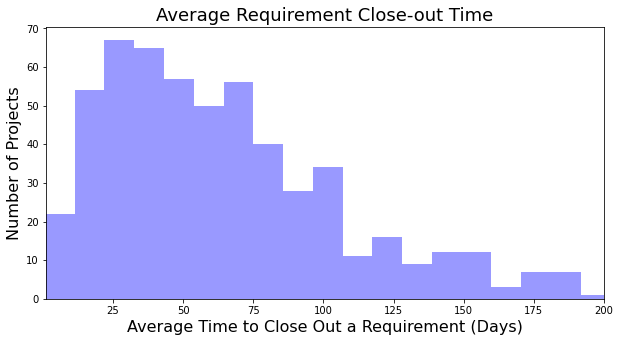

In [67]:
plt.figure(figsize=(10, 5))
sns.distplot(data['avg_active_time'], kde=False, color='blue', bins=50)
plt.title('Average Requirement Close-out Time', fontsize=18)
plt.xlabel('Average Time to Close Out a Requirement (Days)', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([1, 200])

In [68]:
gamma_params = scipy.stats.gamma.fit(data['avg_active_time'])
scipy.stats.kstest(data['avg_active_time'], 'gamma', gamma_params)

KstestResult(statistic=0.9763701039919866, pvalue=0.0)

Next, we run the regression. It performs pretty will with a pseudo-R2 of around 0.51. The results show that the impact of crowd sourcing changes with network structure.

In [69]:
formula = """
avg_active_time ~ crowd_pct + avg_min_path + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age + 
    nodes
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.5108781505611536
8
                 Generalized Linear Model Regression Results                  
Dep. Variable:        avg_active_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      554
Model Family:                   Gamma   Df Model:                            7
Link Function:                    log   Scale:                         0.29622
Method:                          IRLS   Log-Likelihood:                -2662.1
Date:                Thu, 03 Sep 2020   Deviance:                       152.10
Time:                        22:26:12   Pearson chi2:                     164.
No. Iterations:                    17                                         
Covariance Type:            nonrobust                                         
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------

<ipython-input-69-e97aa61acb2b>:8: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))


Next, we perform model diagnostics. While the residual plot shows some positive correlation with the response variable, a regression of the independent variables against the residuals shows no correlation. As a result, we do not have any concerns about biased variables for this model.

(0.0, 250.0)

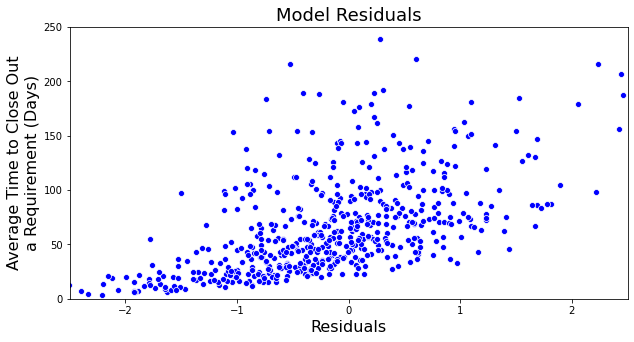

In [70]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['avg_active_time'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Average Time to Close Out\na Requirement (Days)', fontsize=16)
plt.xlim([-2.5, 2.5])
plt.ylim([0, 250])

(-2.5, 2.5)

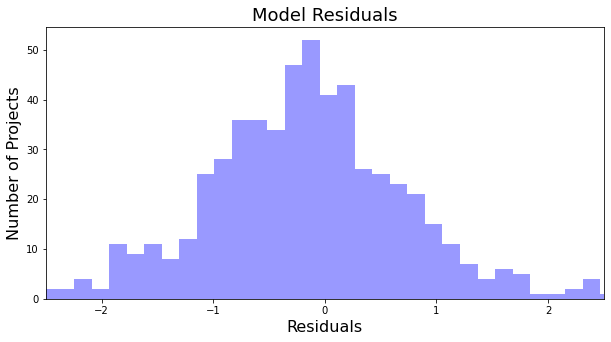

In [71]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=50)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([-2.5, 2.5])

In [72]:
data['close_out_time_resid'] = res.resid_anscombe_scaled
formula = """
close_out_time_resid ~ crowd_pct + avg_min_path + avg_clusteringXcrowd_pct + 
    avg_min_pathXcrowd_pct + gini_coefficientXcrowd_pct + project_age + 
    nodes
"""
y_res, X_res = dmatrices(formula,
                         data=data, return_type='dataframe')
residual_mod = sm.OLS(y_res, X_res)
residual_res = residual_mod.fit()
print(residual_res.summary())

                             OLS Regression Results                             
Dep. Variable:     close_out_time_resid   R-squared:                       0.006
Model:                              OLS   Adj. R-squared:                 -0.007
Method:                   Least Squares   F-statistic:                    0.4780
Date:                  Thu, 03 Sep 2020   Prob (F-statistic):              0.851
Time:                          22:26:13   Log-Likelihood:                -754.98
No. Observations:                   562   AIC:                             1526.
Df Residuals:                       554   BIC:                             1561.
Df Model:                             7                                         
Covariance Type:              nonrobust                                         
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------


The results show that network concentration reduces close out time, while the other network variables increase close out time. Increased crowd sourcing exacerbates the difference. While network variables with more effective structures do not perform worse as crowd sourcing increases, poorer performing networks performing even poorer as crowd sourcing increases.

In [73]:
network_factors = ['avg_min_path']
for factor in network_factors:
    effect = glm_marginal_effect(factor, res, X, data)
    print('{}: {}'.format(factor, effect))

avg_min_path: 1.3039519482522837


In [74]:
calc_total_effect(data, res, X)

50.662635248264756

Text(0.5, 0, 'Share of Crowdsourced Requirements')

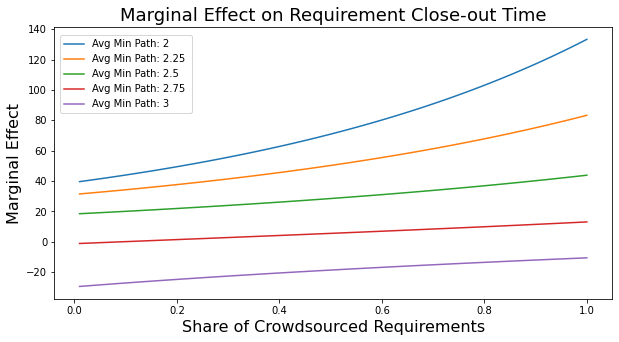

In [75]:
plt.figure(figsize=(10, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Requirement Close-out Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

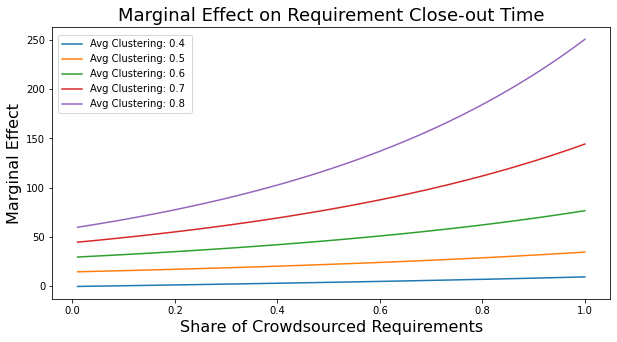

In [76]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Requirement Close-out Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

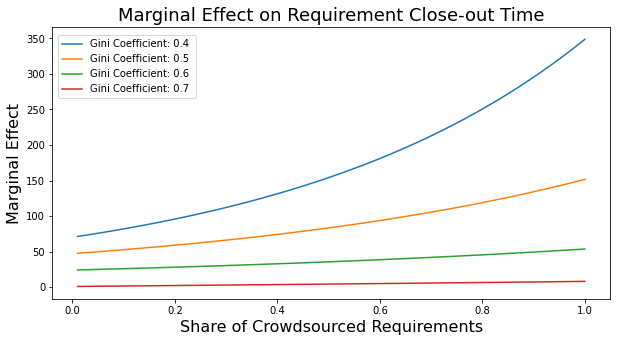

In [77]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(0.01, 0.97), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Requirement Close-out Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

### Retention Time <a id='avg_retention_time'></a>

(1.0, 300.0)

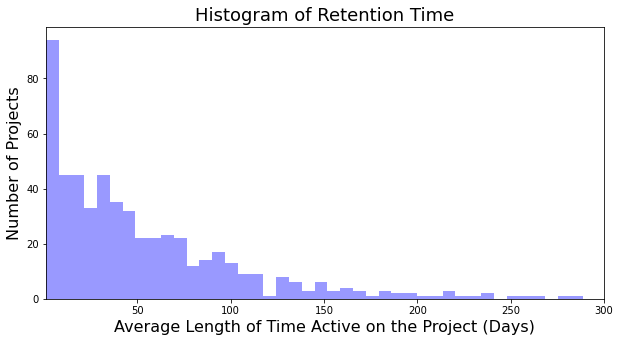

In [78]:
plt.figure(figsize=(10, 5))
sns.distplot(data['avg_retention_time'], kde=False, color='blue', bins=100)
plt.title('Histogram of Retention Time', fontsize=18)
plt.xlabel('Average Length of Time Active on the Project (Days)', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
plt.xlim([1, 300])

In [79]:
gamma_params = scipy.stats.gamma.fit(data['avg_retention_time'].dropna())
scipy.stats.kstest(data['avg_retention_time'].dropna(), 'gamma', gamma_params)

KstestResult(statistic=0.14885176739249784, pvalue=2.4676223559672593e-11)

In [80]:
formula = """
avg_retention_time ~ -1 + crowd_pct + crowd_pct_2 + crowd_pct_3 +
    gini_coefficient + avg_clustering +
    giniXavg_min_path + giniXclustering + 
    avg_min_path_2 + avg_active_time + total_issues + project_age + total_contributors
"""
y, X = dmatrices(formula,
                 data=data, return_type='dataframe')
mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))
res = mod.fit()
print(1 - (res.deviance/res.null_deviance))
print(len(res.params))
print(res.summary())

0.45655818435754836
12
                 Generalized Linear Model Regression Results                  
Dep. Variable:     avg_retention_time   No. Observations:                  562
Model:                            GLM   Df Residuals:                      550
Model Family:                   Gamma   Df Model:                           11
Link Function:                    log   Scale:                         0.68423
Method:                          IRLS   Log-Likelihood:                -2678.1
Date:                Thu, 03 Sep 2020   Deviance:                       478.71
Time:                        22:26:59   Pearson chi2:                     376.
No. Iterations:                    25                                         
Covariance Type:            nonrobust                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
crowd_pct    

<ipython-input-80-3082bfff6a6d>:9: DeprecationWarning: Calling Family(..) with a link class as argument is deprecated.
Use an instance of a link class instead.
  mod = sm.GLM(y, X, family=sm.families.Gamma(link=sm.families.links.log))


(0.0, 200.0)

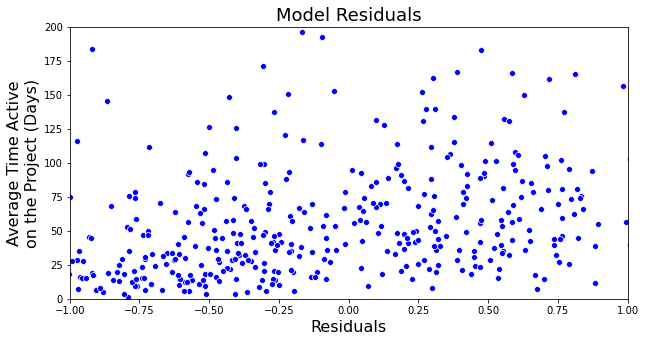

In [81]:
plt.figure(figsize=(10, 5))
sns.scatterplot(x=res.resid_anscombe_scaled, y=data['avg_retention_time'], color='blue')
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Average Time Active\non the Project (Days)', fontsize=16)
plt.xlim([-1, 1])
plt.ylim([0, 200])

Text(0, 0.5, 'Number of Projects')

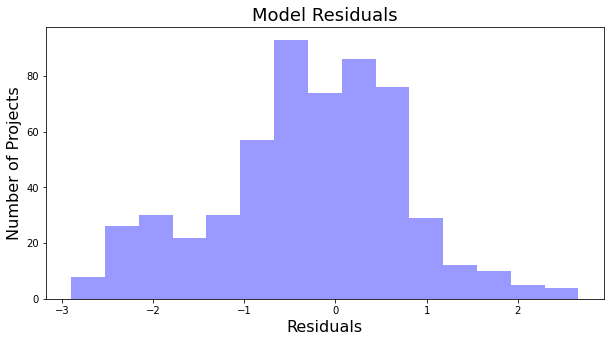

In [82]:
plt.figure(figsize=(10, 5))
sns.distplot(res.resid_anscombe_scaled, kde=False, color='blue', bins=15)
plt.title('Model Residuals', fontsize=18)
plt.xlabel('Residuals', fontsize=16)
plt.ylabel('Number of Projects', fontsize=16)
#plt.xlim([-2.2, 2.2])

In [83]:
data['avg_retention_time_resid'] = res.resid_anscombe_scaled
formula = """
avg_retention_time_resid ~ -1 + crowd_pct + crowd_pct_2 + crowd_pct_3 +
    gini_coefficient + avg_clustering +
    giniXavg_min_path + giniXclustering + 
    avg_min_path_2 + avg_active_time + total_issues + project_age + total_contributors
"""
y_res, X_res = dmatrices(formula,
                         data=data, return_type='dataframe')
residual_mod = sm.OLS(y_res, X_res)
residual_res = residual_mod.fit()
print(residual_res.summary())

                                    OLS Regression Results                                   
Dep. Variable:     avg_retention_time_resid   R-squared (uncentered):                   0.091
Model:                                  OLS   Adj. R-squared (uncentered):              0.071
Method:                       Least Squares   F-statistic:                              4.583
Date:                      Thu, 03 Sep 2020   Prob (F-statistic):                    4.31e-07
Time:                              22:27:00   Log-Likelihood:                         -809.51
No. Observations:                       562   AIC:                                      1643.
Df Residuals:                           550   BIC:                                      1695.
Df Model:                                12                                                  
Covariance Type:                  nonrobust                                                  
                         coef    std err          t      P>|

Text(0.5, 0, 'Share of Crowdsourced Requirements')

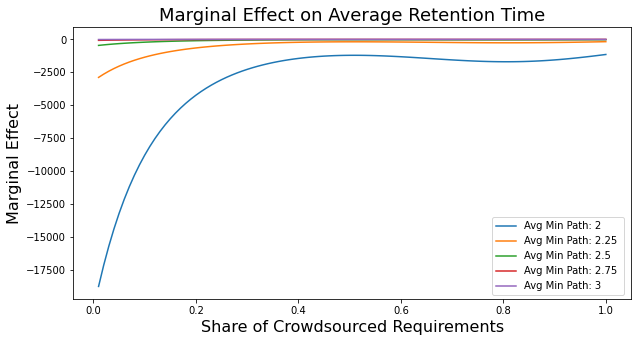

In [84]:
plt.figure(figsize=(10, 5))

for avg_min_path in [2, 2.25, 2.5, 2.75, 3]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Min Path: {} '.format(avg_min_path)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_min_path=avg_min_path)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.75, 0.3), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Average Retention Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

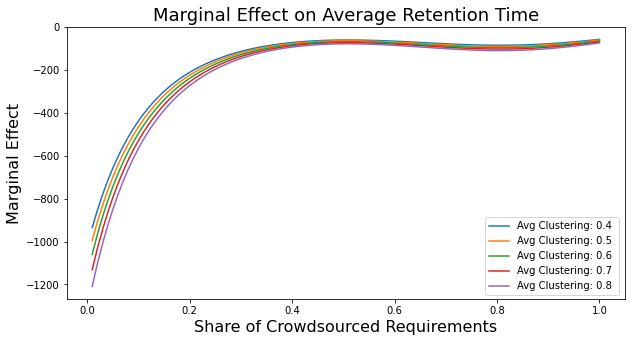

In [85]:
plt.figure(figsize=(10, 5))

for avg_clustering in [0.4, 0.5, 0.6, 0.7, 0.8]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Avg Clustering: {} '.format(avg_clustering)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       avg_clustering=avg_clustering)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)

    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.75, 0.3), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Average Retention Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)

Text(0.5, 0, 'Share of Crowdsourced Requirements')

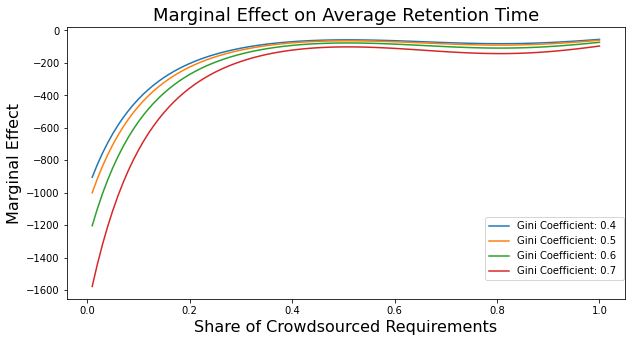

In [86]:
plt.figure(figsize=(10, 5))

for gini_coefficient in [0.4, 0.5, 0.6, 0.7]:
    marginal_effects = {'crowd_pct': [], 'effect': []}
    label = 'Gini Coefficient: {} '.format(gini_coefficient)

    for i in range(100):
        crowd_pct = (i+1)/100
        avg_effect = calc_total_effect(data, res, X,
                                       crowd_pct=crowd_pct, 
                                       gini_coefficient=gini_coefficient)
        marginal_effects['crowd_pct'].append(crowd_pct)
        marginal_effects['effect'].append(avg_effect)
        
    marginal_effects = pd.DataFrame(marginal_effects)
    sns.lineplot(y=marginal_effects['effect'], x=marginal_effects['crowd_pct'], label=label)

plt.legend(bbox_to_anchor=(.75, 0.3), loc=2, borderaxespad=0.)
plt.title('Marginal Effect on Average Retention Time', fontsize=18)
plt.ylabel('Marginal Effect', fontsize=16)
plt.xlabel('Share of Crowdsourced Requirements', fontsize=16)